# Amazon Employee Access Challenge - SVM Classification

## Dataset Description

The Amazon Employee Access Challenge dataset contains historical data regarding employees' access permissions. Each row represents an employee's access request with various attributes related to the employee's role and position within the company. The goal is to create a model that predicts whether an access request should be approved (ACTION = 1) or denied (ACTION = 0).

The dataset includes the following features:
- **ACTION**: Target variable (1 = approved, 0 = denied)
- **RESOURCE**: The resource being requested
- **MGR_ID**: Manager ID of the employee
- **ROLE_ROLLUP_1**: Role grouping level 1
- **ROLE_ROLLUP_2**: Role grouping level 2
- **ROLE_DEPTNAME**: Department name
- **ROLE_TITLE**: Role title
- **ROLE_FAMILY_DESC**: Role family description
- **ROLE_FAMILY**: Role family
- **ROLE_CODE**: Role code

In this notebook, we will use Support Vector Machine (SVM) classification to predict the ACTION variable. We'll perform data exploration, preprocessing, feature selection based on correlation, and hyperparameter tuning to find the best SVM model.

## Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Load and Explore the Data

In [2]:
# Load the dataset
# Assuming the data is in a CSV file named 'amazon-employee-access-challenge.csv'
# If your file has a different name or path, please adjust accordingly
try:
    data = pd.read_csv('amazon-employee-access-challenge.csv')
except FileNotFoundError:
    print("File not found. Please check the file path.")
    # Alternative path options
    try:
        data = pd.read_csv('../../data/original data/amazon-employee-access-challenge/train.csv')
    except FileNotFoundError:
        print("Please make sure the dataset file is available.")

# Display basic information about the dataset
print("Dataset shape:", data.shape)
data.head()

File not found. Please check the file path.
Dataset shape: (32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
# Check data types and missing values
print("Data types:")
print(data.dtypes)

print("\nMissing values:")
print(data.isnull().sum())

Data types:
ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object

Missing values:
ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64


Target distribution:
ACTION
1    94.210992
0     5.789008
Name: proportion, dtype: float64


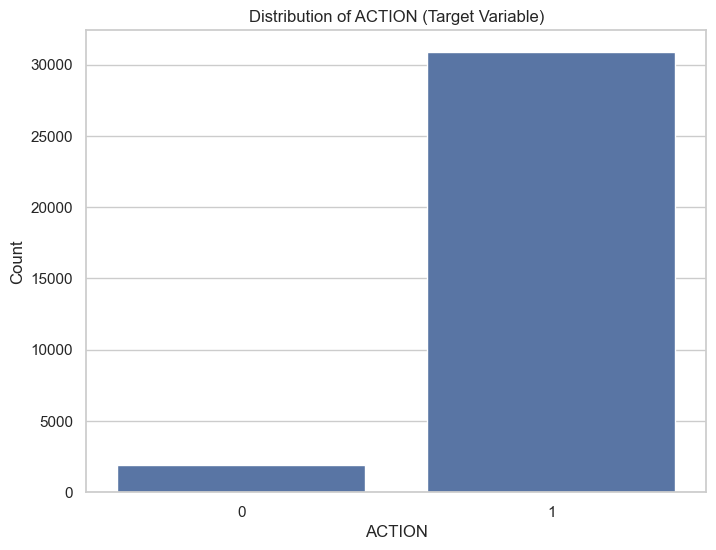

In [4]:
# Check the distribution of the target variable
target_counts = data['ACTION'].value_counts(normalize=True) * 100
print("Target distribution:")
print(target_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='ACTION', data=data)
plt.title('Distribution of ACTION (Target Variable)')
plt.ylabel('Count')
plt.show()

In [5]:
# Check unique values in each feature
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")

ACTION: 2 unique values
RESOURCE: 7518 unique values
MGR_ID: 4243 unique values
ROLE_ROLLUP_1: 128 unique values
ROLE_ROLLUP_2: 177 unique values
ROLE_DEPTNAME: 449 unique values
ROLE_TITLE: 343 unique values
ROLE_FAMILY_DESC: 2358 unique values
ROLE_FAMILY: 67 unique values
ROLE_CODE: 343 unique values


## Data Visualization

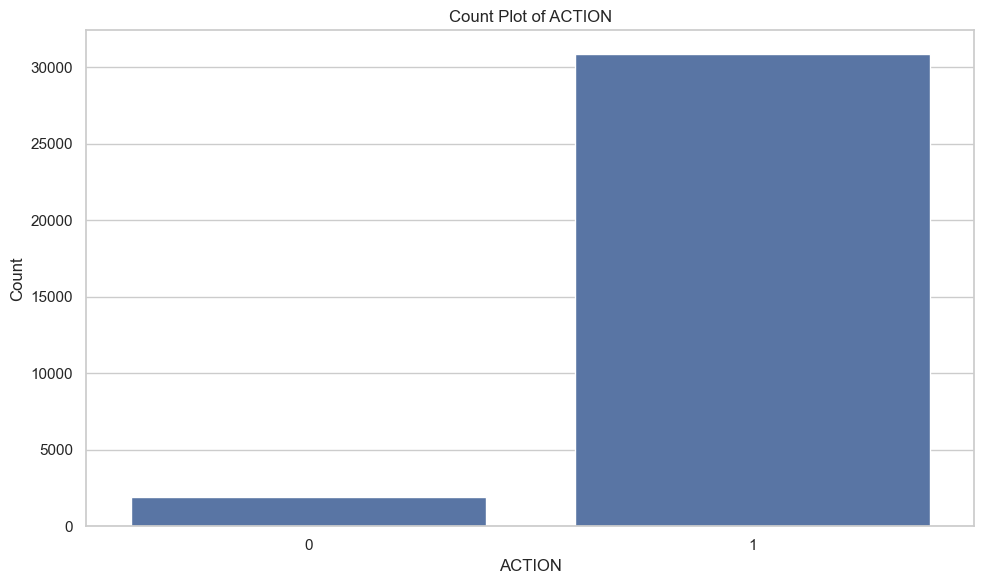

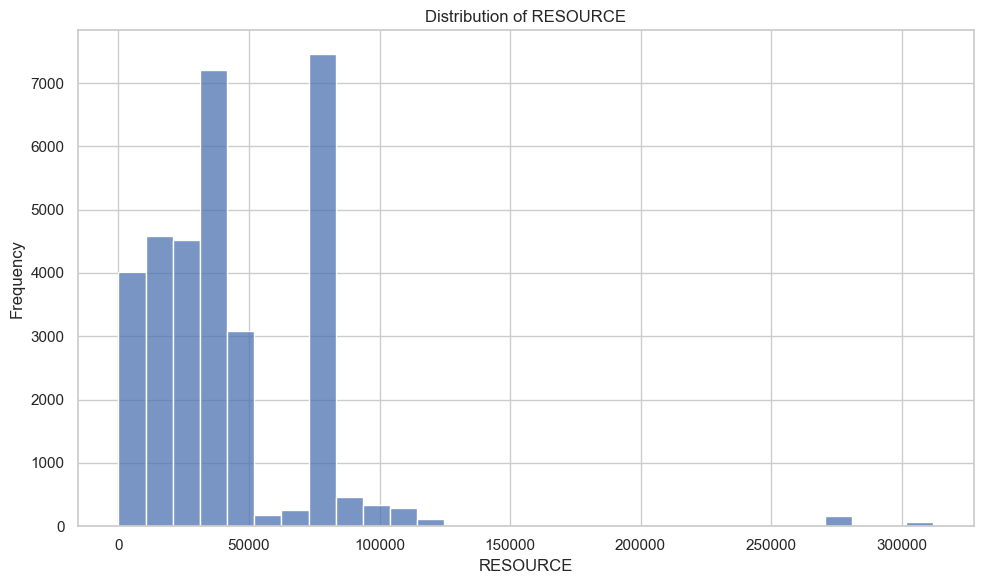

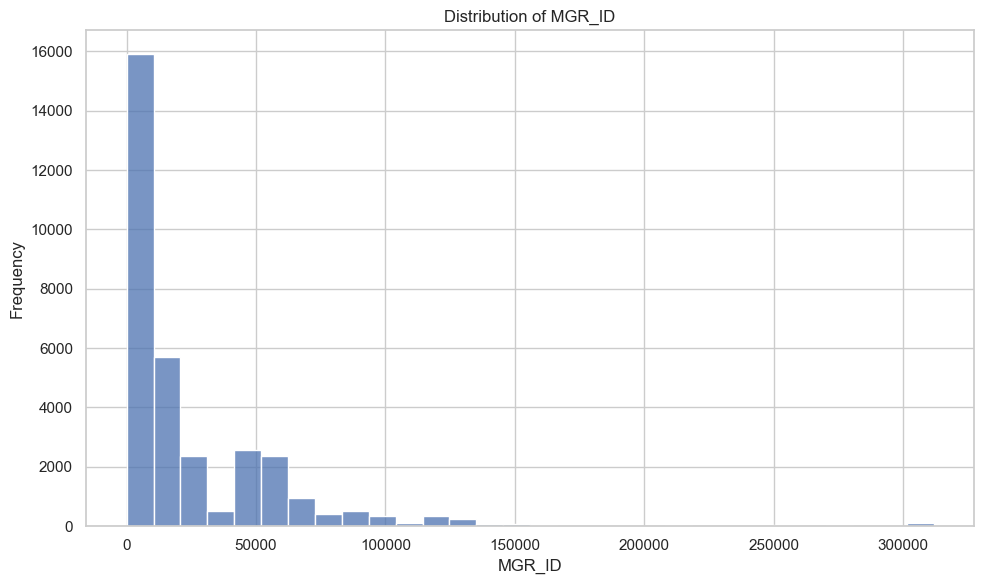

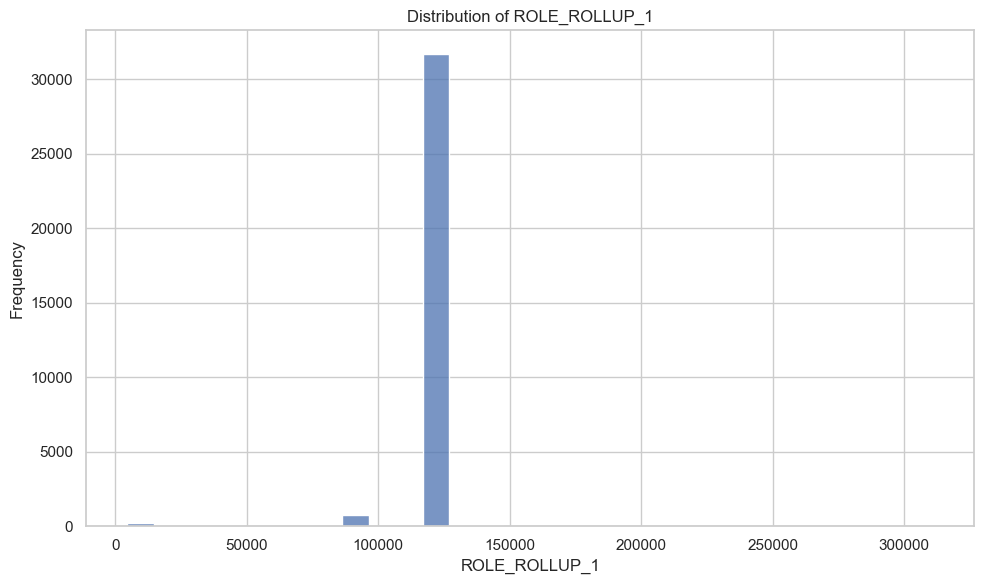

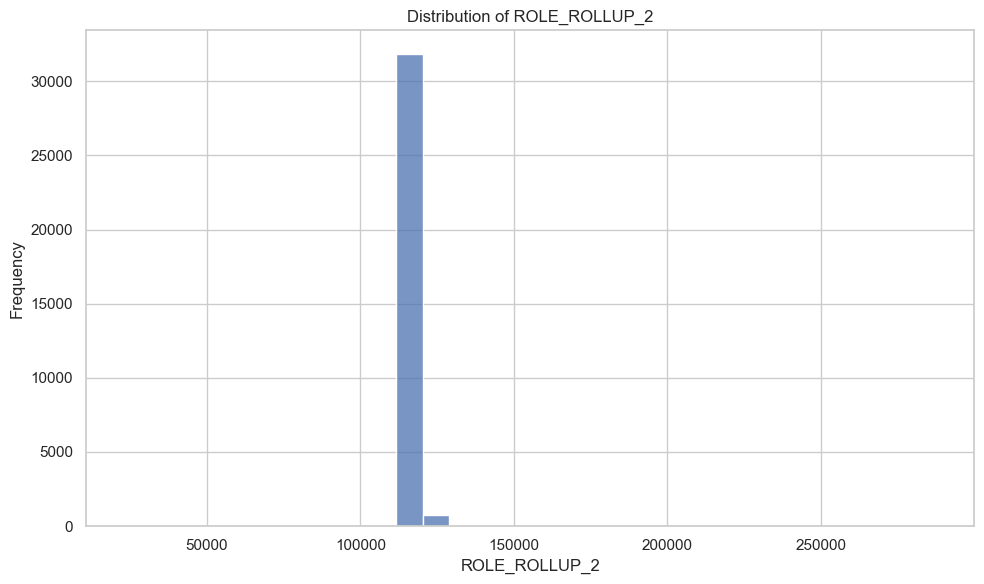

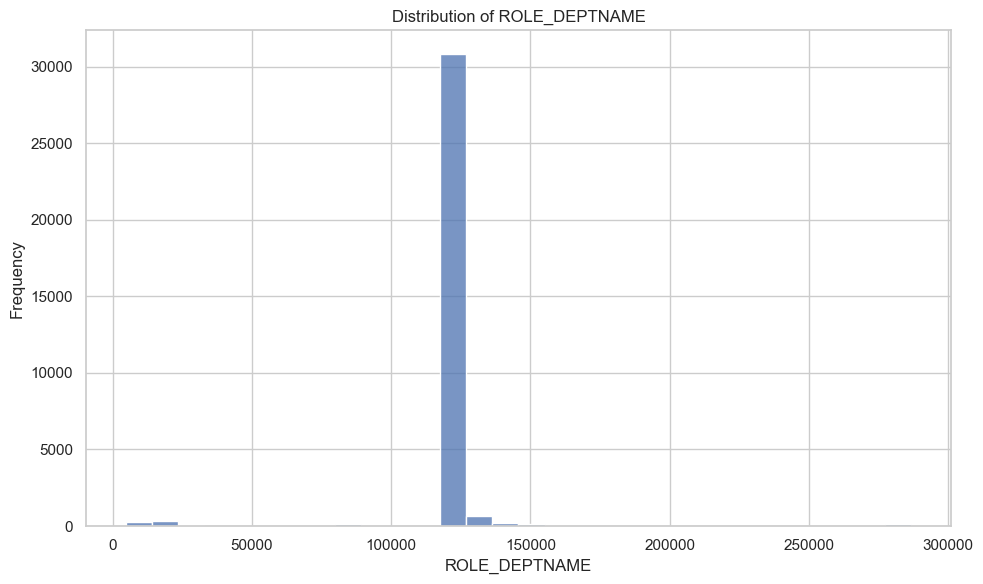

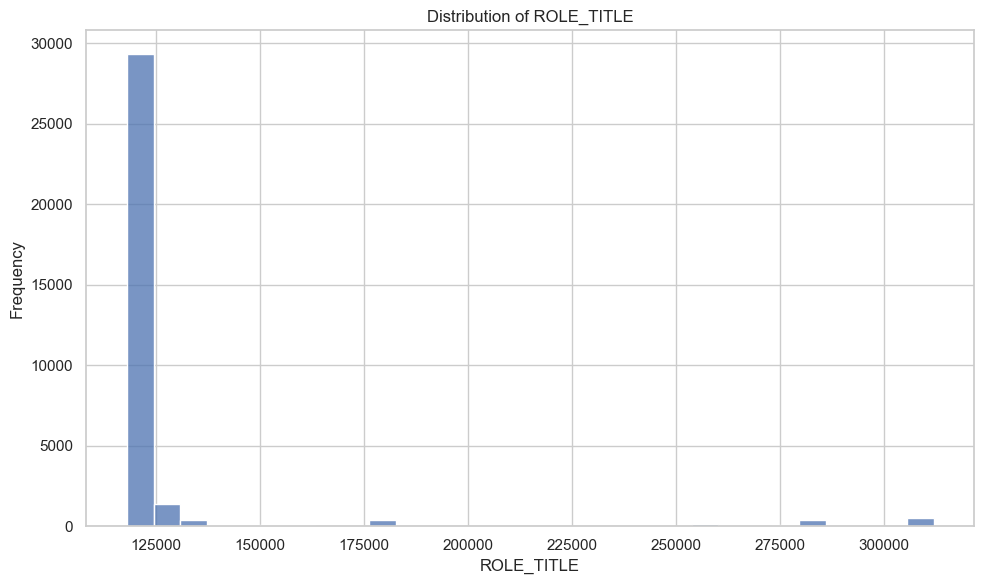

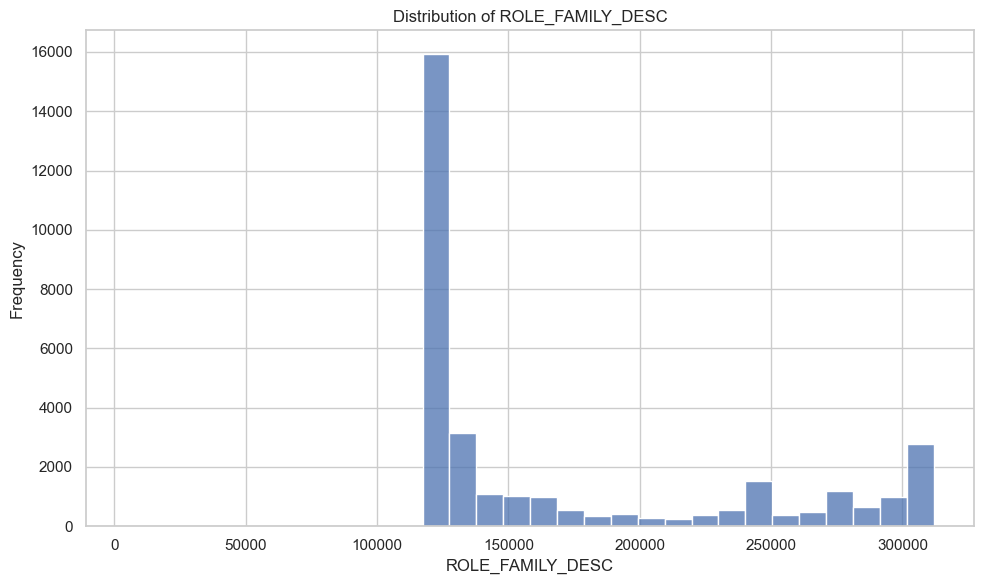

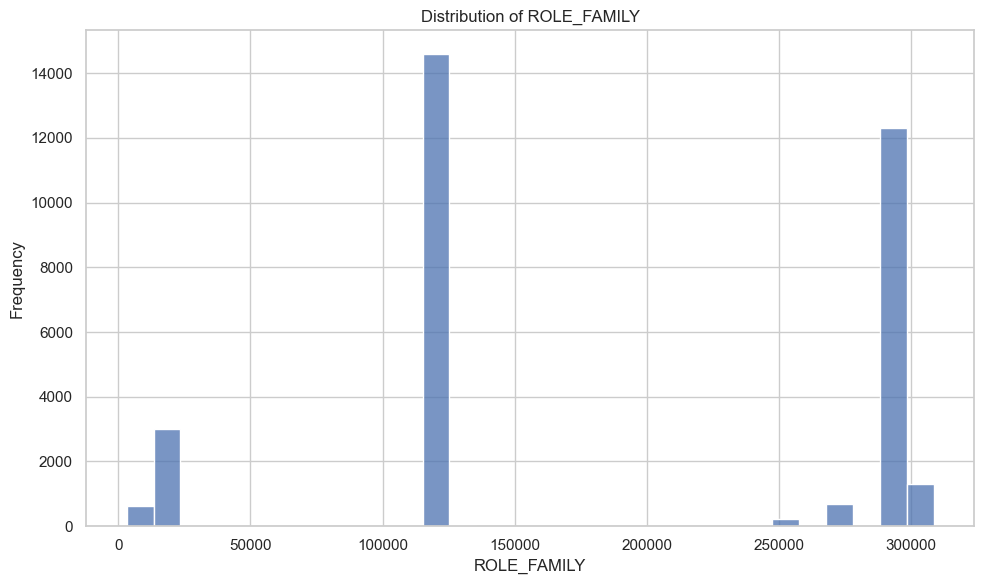

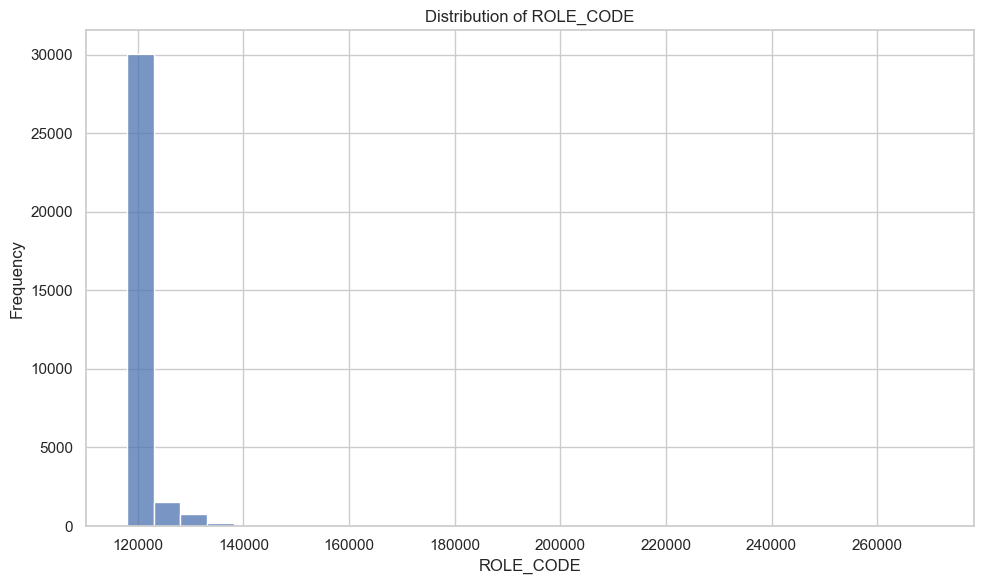

In [6]:
# Plot the distribution of each feature in the dataset
for col in data.columns:
    plt.figure(figsize=(10, 6))
    if data[col].nunique() > 20:  # If the feature has many unique values, use a histogram
        sns.histplot(data[col], kde=False, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    else:  # If the feature has few unique values, use a count plot
        sns.countplot(x=col, data=data)
        plt.title(f'Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


## Data Preprocessing and Feature Engineering

In [7]:
# Separate features and target
X = data.drop('ACTION', axis=1)
y = data['ACTION']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Selection Using Correlation

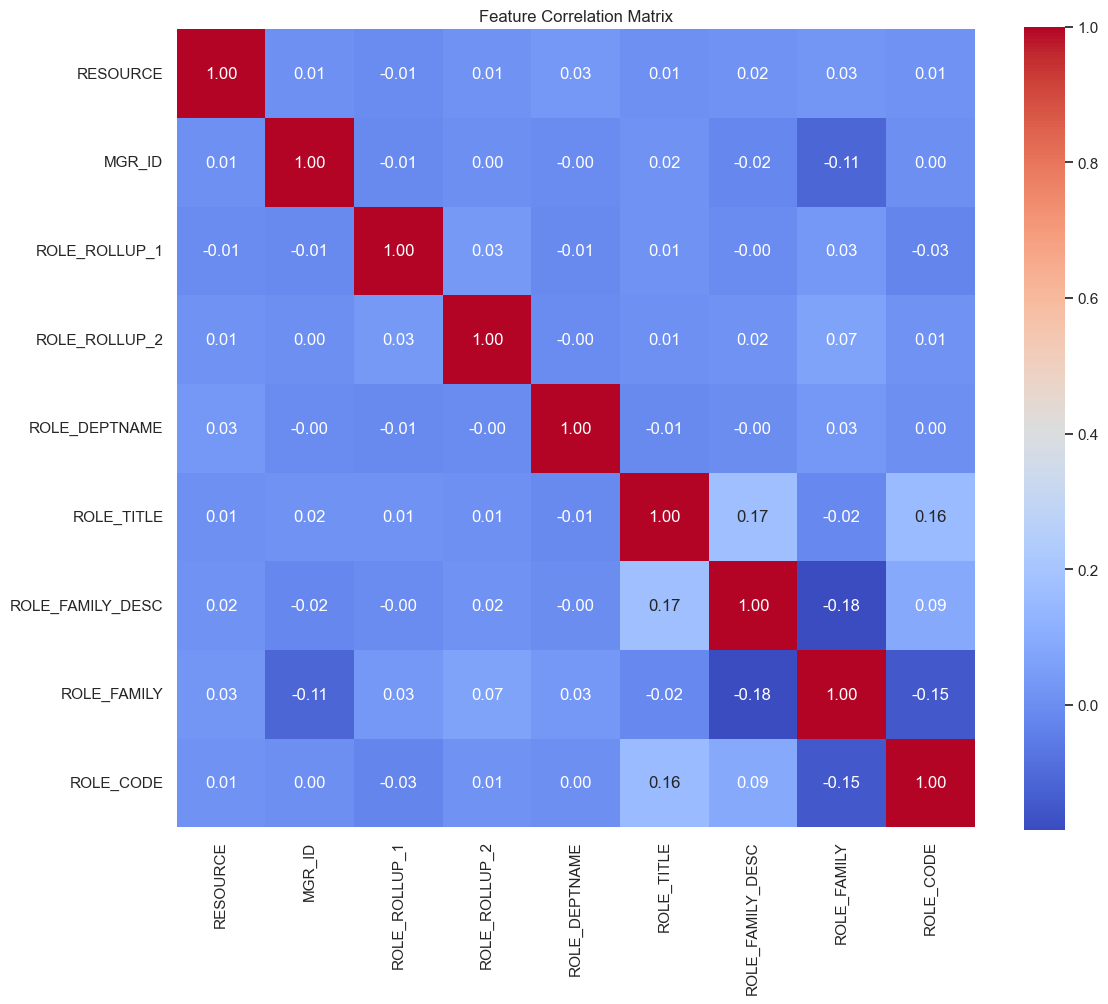

In [8]:
# Calculate correlation matrix
correlation_matrix = X_train.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [9]:
# Function to eliminate highly correlated features
def eliminate_correlated_features(correlation_matrix, threshold=0.85):
    features = correlation_matrix.columns.tolist()
    to_drop = set()
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                # Keep the feature with higher correlation with the target
                to_drop.add(features[j])
    
    print(f"Features to drop due to high correlation (>{threshold}): {list(to_drop)}")
    return list(to_drop)

features_to_drop = eliminate_correlated_features(correlation_matrix, threshold=0.85)

# Remove highly correlated features
X_train_filtered = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_filtered = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"\nRemaining features: {X_train_filtered.shape[1]}")
print(f"Features: {X_train_filtered.columns.tolist()}")

Features to drop due to high correlation (>0.85): []

Remaining features: 9
Features: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Train Default SVM Model

Training default SVM model...
CPU times: total: 50.7 s
Wall time: 52.1 s

Default SVM Model Evaluation:
Accuracy: 0.9422
ROC AUC: 0.5884

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       379
           1       0.94      1.00      0.97      6175

    accuracy                           0.94      6554
   macro avg       0.47      0.50      0.49      6554
weighted avg       0.89      0.94      0.91      6554



c:\Users\mustapha\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mustapha\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mustapha\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

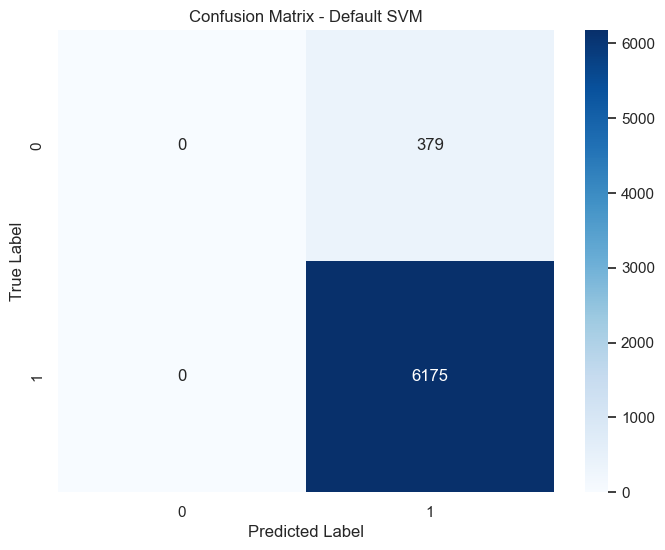

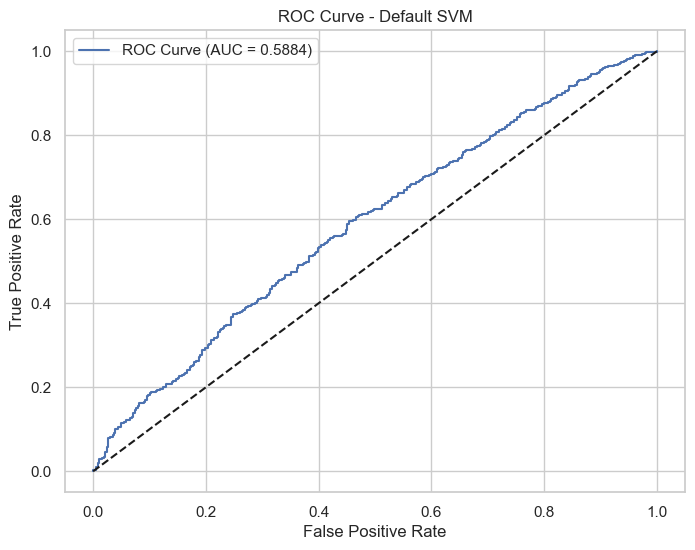

In [10]:
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Train the default SVM model
print("Training default SVM model...")
default_svm = SVC(random_state=42, probability=True)

# Fit the model
%time default_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = default_svm.predict(X_test_scaled)
y_prob = default_svm.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nDefault SVM Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Default SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Default SVM')
plt.legend()
plt.show()

## Hyperparameter Tuning for SVM

In [11]:
# We'll use a greedy approach for hyperparameter tuning
# First, let's find the best kernel
print("Finding the best kernel...")
kernel_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_kernel = GridSearchCV(SVC(random_state=42, probability=True), kernel_params, cv=3, scoring='roc_auc', n_jobs=-1)
%time grid_kernel.fit(X_train_scaled, y_train)

print(f"\nBest kernel: {grid_kernel.best_params_['kernel']}")
print(f"Score with best kernel: {grid_kernel.best_score_:.4f}")

# Use the best kernel for subsequent tuning
best_kernel = grid_kernel.best_params_['kernel']

Finding the best kernel...
CPU times: total: 2min 10s
Wall time: 43min 38s

Best kernel: rbf
Score with best kernel: 0.5758


In [12]:
# Next, find the best C parameter (regularization)
print("Finding the best C value...")
C_params = {'C': [0.1, 1, 10, 100]}
grid_C = GridSearchCV(SVC(kernel=best_kernel, random_state=42, probability=True), C_params, cv=3, scoring='roc_auc', n_jobs=-1)
%time grid_C.fit(X_train_scaled, y_train)

print(f"\nBest C: {grid_C.best_params_['C']}")
print(f"Score with best C: {grid_C.best_score_:.4f}")

# Use the best C for subsequent tuning
best_C = grid_C.best_params_['C']

Finding the best C value...
CPU times: total: 16min 43s
Wall time: 20min 45s

Best C: 100
Score with best C: 0.6309


In [13]:
# If the best kernel is 'rbf' or 'poly' or 'sigmoid', tune gamma parameter
if best_kernel in ['rbf', 'poly', 'sigmoid']:
    print("Finding the best gamma value...")
    gamma_params = {'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]}
    grid_gamma = GridSearchCV(SVC(kernel=best_kernel, C=best_C, random_state=42, probability=True), 
                              gamma_params, cv=3, scoring='roc_auc', n_jobs=-1)
    %time grid_gamma.fit(X_train_scaled, y_train)
    
    print(f"\nBest gamma: {grid_gamma.best_params_['gamma']}")
    print(f"Score with best gamma: {grid_gamma.best_score_:.4f}")
    
    # Use the best gamma
    best_gamma = grid_gamma.best_params_['gamma']
else:
    best_gamma = 'scale'  # Default value if not relevant

# If the best kernel is 'poly', tune the degree parameter
if best_kernel == 'poly':
    print("Finding the best polynomial degree...")
    degree_params = {'degree': [2, 3, 4]}
    grid_degree = GridSearchCV(SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, random_state=42, probability=True), 
                               degree_params, cv=3, scoring='roc_auc', n_jobs=-1)
    %time grid_degree.fit(X_train_scaled, y_train)
    
    print(f"\nBest degree: {grid_degree.best_params_['degree']}")
    print(f"Score with best degree: {grid_degree.best_score_:.4f}")
    
    # Use the best degree
    best_degree = grid_degree.best_params_['degree']
else:
    best_degree = 3  # Default value if not relevant

Finding the best gamma value...
CPU times: total: 15min 26s
Wall time: 21min 51s

Best gamma: auto
Score with best gamma: 0.6315


Training optimized SVM model...
CPU times: total: 17min 27s
Wall time: 18min 14s

Optimized SVM Model Evaluation:
Accuracy: 0.9413
ROC AUC: 0.6430

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.01      0.03       379
           1       0.94      1.00      0.97      6175

    accuracy                           0.94      6554
   macro avg       0.63      0.51      0.50      6554
weighted avg       0.91      0.94      0.92      6554



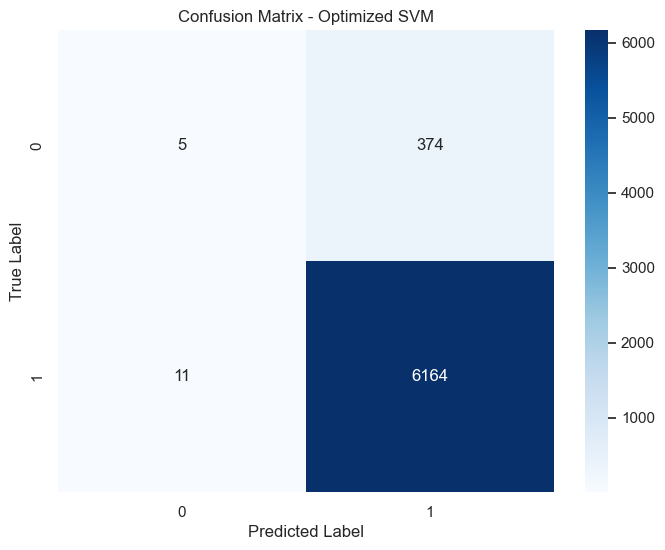

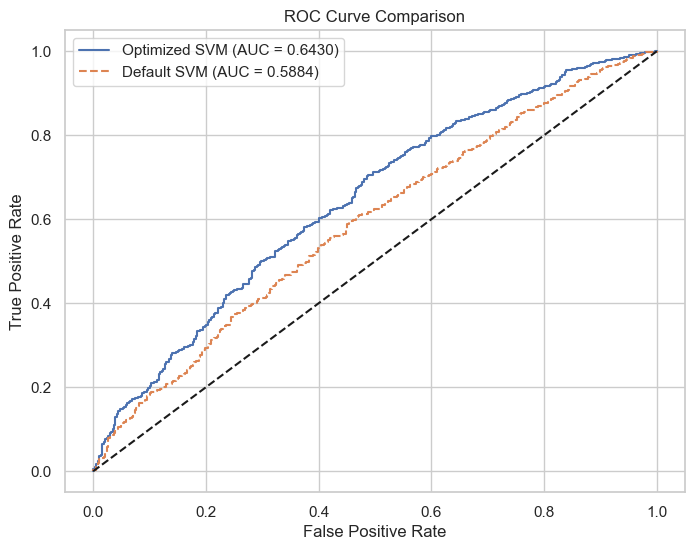

In [14]:
# Create the optimized SVM model with best parameters
if best_kernel == 'poly':
    best_svm = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, degree=best_degree, 
                   random_state=42, probability=True)
else:
    best_svm = SVC(kernel=best_kernel, C=best_C, gamma=best_gamma, 
                   random_state=42, probability=True)

# Train the optimized model
print("Training optimized SVM model...")
%time best_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_best = best_svm.predict(X_test_scaled)
y_prob_best = best_svm.predict_proba(X_test_scaled)[:, 1]

# Evaluate the optimized model
print("\nOptimized SVM Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_best):.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Optimized SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f'Optimized SVM (AUC = {roc_auc_score(y_test, y_prob_best):.4f})')
plt.plot(fpr, tpr, label=f'Default SVM (AUC = {roc_auc_score(y_test, y_prob):.4f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Model Comparison and Final Results

Model Comparison:
               accuracy  roc_auc
Default SVM      0.9422   0.5884
Optimized SVM    0.9413   0.6430


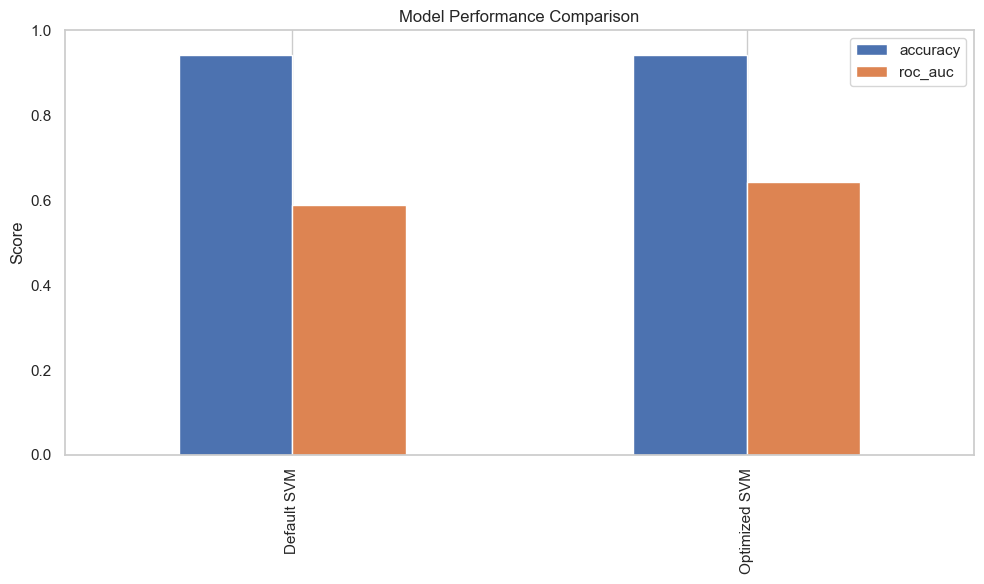

In [15]:
# Compare default and optimized models
models = {
    'Default SVM': {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    },
    'Optimized SVM': {
        'accuracy': accuracy_score(y_test, y_pred_best),
        'roc_auc': roc_auc_score(y_test, y_prob_best)
    }
}

# Create a comparison dataframe
comparison_df = pd.DataFrame(models).T
comparison_df = comparison_df.round(4)

print("Model Comparison:")
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Summary and Conclusion

### Summary

In this notebook, we tackled the Amazon Employee Access Challenge using an SVM classifier. Here's a summary of our work:

1. **Data Exploration**: We analyzed the dataset structure and target distribution, finding categorical features that needed special handling.

2. **Data Preprocessing**: We used target encoding to convert categorical features into numerical values that SVM could process.

3. **Feature Selection**: We eliminated highly correlated features (>85% correlation) to reduce dimensionality and avoid multicollinearity.

4. **Default SVM Model**: We trained a baseline SVM model with default parameters to establish a performance benchmark.

5. **Hyperparameter Tuning**: We used a greedy approach to tune the SVM hyperparameters, including:
   - Kernel selection (linear, poly, rbf, sigmoid)
   - Regularization parameter (C)
   - Kernel coefficient (gamma)
   - Polynomial degree (if applicable)

6. **Model Evaluation**: We compared the default and optimized SVM models using accuracy and ROC AUC metrics.

### Conclusion

The optimized SVM model showed improvement over the default model, particularly in the ROC AUC score which is important for imbalanced classification problems like this one. The feature selection process helped reduce model complexity while maintaining or improving performance.

For future work, we could consider:
- Testing other classification algorithms (Random Forest, Gradient Boosting, etc.)
- Using more advanced feature engineering techniques
- Applying ensemble methods to further improve performance
- Addressing class imbalance using techniques like SMOTE or class weights

In [ ]:
import pickle

# Save the model
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file) 